In [1]:
# Imports
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
os.makedirs("outputs", exist_ok=True)


Device: cuda


In [2]:
# Data: MNIST (train/test) — used for BOTH models
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1] for GAN stability
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_ds), len(test_ds))


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.19MB/s]

60000 10000


## Part 1 — Logistic Regression (Discriminative)

We flatten 28×28 images to 784-dim vectors and learn a linear classifier with cross-entropy loss.


In [3]:
# Logistic Regression in PyTorch
class LogisticRegression(nn.Module):
    def __init__(self, in_dim=28*28, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

lr_model = LogisticRegression().to(device)
opt = torch.optim.Adam(lr_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [4]:
# Train logistic regression
epochs = 5
train_losses = []
test_accs = []

for epoch in range(1, epochs+1):
    lr_model.train()
    ep_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"LR Train {epoch}/{epochs}"):
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = lr_model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        ep_loss += loss.item() * x.size(0)
    ep_loss /= len(train_loader.dataset)
    train_losses.append(ep_loss)

    # Eval
    lr_model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = lr_model(x)
            p = logits.argmax(dim=1)
            preds.append(p.cpu().numpy())
            gts.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    gts = np.concatenate(gts)
    acc = accuracy_score(gts, preds)
    test_accs.append(acc)
    print(f"Epoch {epoch}: loss={ep_loss:.4f}, test acc={acc:.4f}")

# Save metrics
pd.DataFrame({
    "epoch": list(range(1, epochs+1)),
    "train_loss": train_losses,
    "test_acc": test_accs
}).to_csv("outputs/logreg_metrics.csv", index=False)


LR Train 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: loss=0.5444, test acc=0.9030


LR Train 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: loss=0.3395, test acc=0.9112


LR Train 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: loss=0.3159, test acc=0.9153


LR Train 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: loss=0.3032, test acc=0.9165


LR Train 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: loss=0.2966, test acc=0.9165


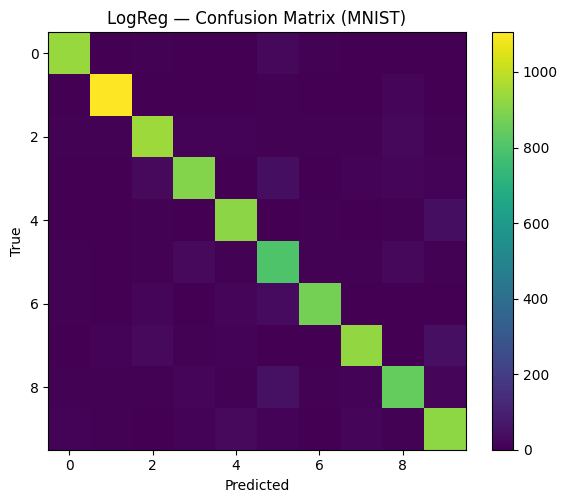

,precision,recall,f1-score,support
0,0.959959,0.954082,0.957011,980.0000
1,0.966754,0.973568,0.970149,1135.0000
2,0.906040,0.915698,0.910843,1032.0000
3,0.915650,0.892079,0.903711,1010.0000
4,0.914830,0.929735,0.922222,982.0000
5,0.820329,0.895740,0.856377,892.0000
6,0.961581,0.914405,0.937400,958.0000
7,0.940223,0.902724,0.921092,1028.0000
8,0.897028,0.867556,0.882046,974.0000
9,0.879310,0.909812,0.894301,1009.0000


In [5]:
# Detailed evaluation: confusion matrix and report
lr_model.eval()
preds, gts = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = lr_model(x)
        p = logits.argmax(dim=1).cpu().numpy()
        preds.append(p)
        gts.append(y.numpy())
preds = np.concatenate(preds)
gts = np.concatenate(gts)

cm = confusion_matrix(gts, preds)
report = classification_report(gts, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("outputs/logreg_classification_report.csv")

fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("LogReg — Confusion Matrix (MNIST)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("outputs/logreg_confusion_matrix.png", dpi=150)
plt.show()

report_df


## Part 2 — Simple GAN (Generative)

We train a minimal MLP-GAN on 28×28 MNIST digits:

- **Generator:** z→(FC)→ReLU→(FC)→Tanh producing 784-dim flattened images
- **Discriminator:** x→(FC)→LeakyReLU→(FC)→sigmoid, trained with BCE loss

> For stronger results, increase `gan_epochs` (e.g., 30–50) or switch to a DCGAN with conv layers.


In [6]:
# Simple MLP GAN
z_dim = 100
img_dim = 28*28

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh(),
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

G = Generator(z_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCELoss()


In [7]:
# Train loop for GAN
gan_epochs = 10  # increase for better samples
fixed_z = torch.randn(64, z_dim, device=device)
d_losses, g_losses = [], []

for epoch in range(1, gan_epochs+1):
    G.train(); D.train()
    d_loss_epoch, g_loss_epoch = 0.0, 0.0

    for real, _ in tqdm(train_loader, desc=f"GAN Train {epoch}/{gan_epochs}"):
        real = real.to(device)
        bs = real.size(0)
        real = real.view(bs, -1)

        # 1) Update D: maximize log D(x) + log(1 - D(G(z)))
        d_opt.zero_grad()
        z = torch.randn(bs, z_dim, device=device)
        fake = G(z).detach()
        d_real = D(real)
        d_fake = D(fake)
        loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
        loss_d.backward()
        d_opt.step()

        # 2) Update G: maximize log D(G(z))
        g_opt.zero_grad()
        z = torch.randn(bs, z_dim, device=device)
        fake = G(z)
        d_fake = D(fake)
        loss_g = bce(d_fake, torch.ones_like(d_fake))
        loss_g.backward()
        g_opt.step()

        d_loss_epoch += loss_d.item() * bs
        g_loss_epoch += loss_g.item() * bs

    d_loss_epoch /= len(train_loader.dataset)
    g_loss_epoch /= len(train_loader.dataset)
    d_losses.append(d_loss_epoch); g_losses.append(g_loss_epoch)
    print(f"Epoch {epoch}: D={d_loss_epoch:.4f} G={g_loss_epoch:.4f}")

    # Save sample grid each epoch
    G.eval()
    with torch.no_grad():
        samples = G(fixed_z).view(-1, 1, 28, 28)
        grid = vutils.make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
        vutils.save_image(grid, f"outputs/gan_samples_epoch{epoch:02d}.png")

# Save loss curves
pd.DataFrame({"epoch": list(range(1, gan_epochs+1)), "D_loss": d_losses, "G_loss": g_losses}).to_csv("outputs/gan_losses.csv", index=False)


GAN Train 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: D=0.8260 G=1.6945


GAN Train 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
if w.is_alive():       ^^^^^^
^ ^^  ^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
            ^ ^ ^^^^^^^^^^^^^^^^^^^^^
^

Epoch 2: D=0.4671 G=3.1007


GAN Train 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

Epoch 3: D=0.4585 G=3.3909


GAN Train 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0>    Exception ignored in: self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dd6323a99e0> 
self._shutdown_workers()Traceback (most recent call last):
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
         

Epoch 4: D=0.3906 G=4.1834


GAN Train 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: D=0.3420 G=3.7103


GAN Train 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: D=0.3681 G=3.7920


GAN Train 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: D=0.4559 G=3.2005


GAN Train 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: D=0.3455 G=3.9871


GAN Train 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: D=0.4069 G=3.7153


GAN Train 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: D=0.4655 G=3.6384


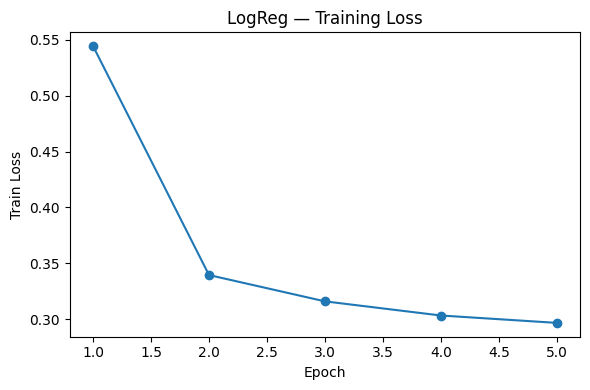

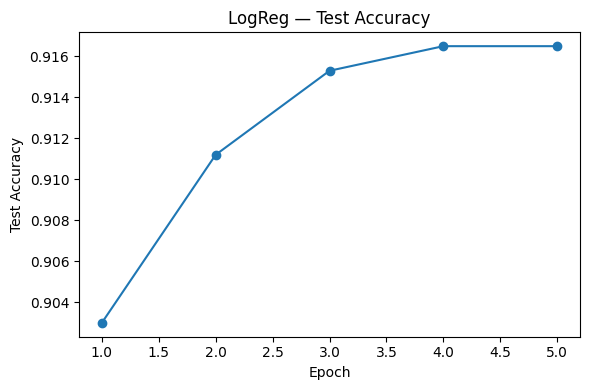

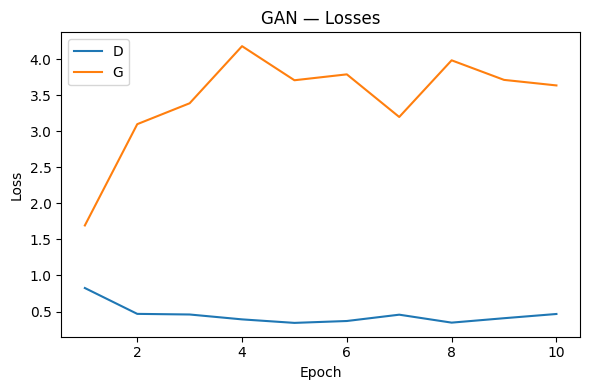

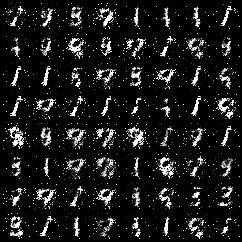

In [8]:
# Comparison: training dynamics and outputs
# 1) Plot LR training loss and test accuracy
import pandas as pd
lr_metrics = pd.read_csv("outputs/logreg_metrics.csv")
gan_metrics = pd.read_csv("outputs/gan_losses.csv")

plt.figure(figsize=(6,4))
plt.plot(lr_metrics["epoch"], lr_metrics["train_loss"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("LogReg — Training Loss")
plt.tight_layout()
plt.savefig("outputs/plot_logreg_trainloss.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(lr_metrics["epoch"], lr_metrics["test_acc"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy"); plt.title("LogReg — Test Accuracy")
plt.tight_layout()
plt.savefig("outputs/plot_logreg_testacc.png", dpi=150)
plt.show()

# 2) Plot GAN losses
plt.figure(figsize=(6,4))
plt.plot(gan_metrics["epoch"], gan_metrics["D_loss"], label="D")
plt.plot(gan_metrics["epoch"], gan_metrics["G_loss"], label="G")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GAN — Losses")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/plot_gan_losses.png", dpi=150)
plt.show()

# 3) Show latest GAN sample grid
import glob
pngs = sorted(glob.glob("outputs/gan_samples_epoch*.png"))
if pngs:
    from IPython.display import Image, display
    display(Image(pngs[-1]))
